<h1 align ="center"> REST API Grounding Enhanchment Samples</h1>
<hr>
   
# Chat Completions

In [5]:
import base64
import json
import os
import re
import matplotlib.pyplot as plt
import textwrap
import random
from PIL import Image, ImageDraw, ImageFont
%run shared_functions.ipynb

### Setup Parameters


Here we will load the configurations from _config.json_ file to setup vision_api_key, and vision_api_endpoint.

In [6]:
# Load config values
with open(r'config.json') as config_file:
    config_details = json.load(config_file)

# Setting up the vision resource key
vision_api_key = os.getenv("VISION_API_KEY")

# The base URL for your vision resource endpoint, e.g. "https://<your-resource-name>.cognitiveservices.azure.com"
vision_api_endpoint = config_details['VISION_API_ENDPOINT']

The image shows a luxurious interior with an elegant marble staircase that spirals upwards between two floors, flanked by sleek black bannisters with shiny brass handrails.
The floor is a polished checkerboard pattern of black and white tiles, and the spacious area is surrounded by white columns and adorned with modern furniture, including black leather couches with cream cushions.
The setting is illuminated by natural light streaming in from the glass ceiling above and complemented by recessed ceiling lights, creating a grand and opulent ambiance.


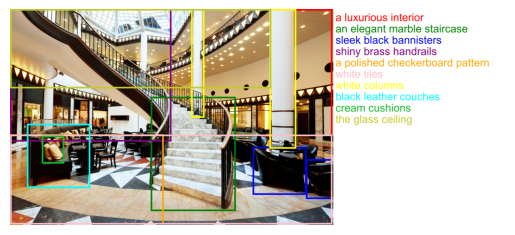

In [7]:
def random_color():
    """ Generate a random color. """
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

def draw_groundings(image_path, groundings):
    # Load the image
    original_image = Image.open(image_path)
    width, height = original_image.size

    box_width = max(2, width // 200)
    font_size = max(15, height // 20)

    extended_width = width + 1500  # More space for text
    image = Image.new('RGB', (extended_width, height), 'white')
    image.paste(original_image, (0, 0))

    draw = ImageDraw.Draw(image)

    predefined_colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'yellow', 'cyan']
    text_color_map = {}  # Dictionary to map text to colors
    text_x = width + 20  # Starting just after the original image
    text_y = 20  # Initial vertical position

    # Iterate over each grounding in the data
    for grounding in groundings:
        text = grounding['text']
        polygon = grounding['polygon']

        if text not in text_color_map:
            if predefined_colors:
                text_color_map[text] = predefined_colors.pop(0)
            else:
                text_color_map[text] = random_color()

        color = text_color_map[text]
        absolute_polygon = [(p['x'] * width, p['y'] * height) for p in polygon]

        bounding_box = [min(p[0] for p in absolute_polygon), min(p[1] for p in absolute_polygon),
                        max(p[0] for p in absolute_polygon), max(p[1] for p in absolute_polygon)]
        draw.rectangle(bounding_box, outline=color, width=box_width)

    # Draw the text on the extended right side of the image
    for text, color in text_color_map.items():
        try:
            font = ImageFont.truetype("arial.ttf", font_size)
        except IOError:
            font = ImageFont.load_default()

        # Text wrapping
        wrapped_text = textwrap.fill(text, width=40)  # Adjust width as needed
        for line in wrapped_text.split('\n'):
            if text_y + font_size < height:
                draw.text((text_x, text_y), line, fill=color, font=font)
                text_y += font_size + 5  # Increment y position for next line
            else:
                break  # Stop if there's no more space

    # Save or display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

#Image Description Assistant
image_file_path = "../../common/images/ImageDescriptionAssistant.jpg"  # Update with your image path
sys_message = "You are an AI assistant that helps people craft a clear and detailed sentence that describes the content depicted in an image."
user_prompt = "Describe image"

# Encode the image in base64
with open(image_file_path, 'rb') as image_file:
    encoded_image = base64.b64encode(image_file.read()).decode('utf-8')

messages = [
    {
      "role": "system",
      "content": [
          {
            "type": "text", 
            "text": sys_message
          }
      ]
    },
    {
      "role": "user",
      "content": [
          {
            "type": "text",
            "text": user_prompt # Prompt for the user
          },
          {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{encoded_image}" # Image to be processed
          }
          }
      ]
    }
  ]

vision_api_config = {
    "endpoint": vision_api_endpoint,
    "key": vision_api_key
}

# Send the request and handle the response
try:
    response_content = call_GPT4V_image(messages, grounding=True, vision_api=vision_api_config)
    text = response_content['choices'][0]['message']['content']
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    for sentence in sentences:  # Print the content of the response
        print(sentence)
    draw_groundings(image_file_path,response_content['choices'][0]['enhancements']['grounding']['lines'][0]['spans'])
except Exception as e:
    raise SystemExit(f"Failed to call GPT-4V API. Error: {e}")